In [319]:
import carveme
import reframed
from pathlib import Path
import numpy as np
import pandas as pd
from reframed import load_cbmodel, save_cbmodel, Environment
from carveme.reconstruction.utils import load_media_db
from carveme.reconstruction.gapfilling import multiGapFill
from carveme.reconstruction import carving
import matplotlib.pyplot as plt

In [3]:
repo_path = Path('/Users/ssulheim/git/mwf_gems')
gapfilling_data_folder = repo_path / 'gapfilling_data'
M9_minimal_media_file = gapfilling_data_folder / 'M9_minimal_media_bigg.csv'
vitamins_file = gapfilling_data_folder / 'vitamins_bigg.csv'
bigg_universe_fn = gapfilling_data_folder / 'universe_bacteria.xml'#'bigg_universe.xml'


In [205]:
media_db_file = '/Users/ssulheim/anaconda3/lib/python3.11/site-packages/carveme/data/input/media_db.tsv'
media_db = load_media_db(media_db_file)

In [230]:
init_env = Environment.from_compounds(media_db['M9'])

In [231]:
del init_env['R_EX_ni2_e']
del init_env['R_EX_na1_e']

In [295]:
universe = reframed.load_cbmodel(bigg_universe_fn)
universe.solver = 'gurobi'
# for r_id in universe.get_exchange_reactions():
#     r = universe.reactions[r_id]
#     r.lb = 0
# init_env.apply(universe)

In [321]:
model = create_random_model(universe, media_db, N_random = 1000)


In [311]:
reframed.FBA(model, constraints={'R_EX_glc__D_e':-10})

Objective: 0.783428179338093
Status: Optimal

In [312]:
# model = multiGapFill(model, universe, ['M9'], media_db)

In [313]:
model.reactions.R_ATPM.lb = 3.15

In [314]:
ancestor = model.copy()

In [315]:
reframed.FBA(ancestor, constraints=init_env)

/Users/ssulheim/anaconda3/lib/python3.11/site-packages/reframed/solvers/gurobi_solver.py:236: UserWarning: Constrained variable 'R_EX_fe2_e' not previously declared
  warn(f"Constrained variable '{r_id}' not previously declared")
/Users/ssulheim/anaconda3/lib/python3.11/site-packages/reframed/solvers/gurobi_solver.py:236: UserWarning: Constrained variable 'R_EX_mobd_e' not previously declared
  warn(f"Constrained variable '{r_id}' not previously declared")
/Users/ssulheim/anaconda3/lib/python3.11/site-packages/reframed/solvers/gurobi_solver.py:236: UserWarning: Constrained variable 'R_EX_na1_e' not previously declared
  warn(f"Constrained variable '{r_id}' not previously declared")
/Users/ssulheim/anaconda3/lib/python3.11/site-packages/reframed/solvers/gurobi_solver.py:236: UserWarning: Constrained variable 'R_EX_ni2_e' not previously declared
  warn(f"Constrained variable '{r_id}' not previously declared")


Objective: 0.7488243590182476
Status: Optimal

In [316]:
model, growth, n_reactions = evolve_model(model, universe, timesteps=1000)

/Users/ssulheim/anaconda3/lib/python3.11/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_fe2_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/ssulheim/anaconda3/lib/python3.11/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_mobd_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/ssulheim/anaconda3/lib/python3.11/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_na1_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/ssulheim/anaconda3/lib/python3.11/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_ni2_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/ssulheim/anaconda3/lib/python3.11/site-packages/reframed/solvers/gurobi_solver.py:236: UserWarning: Constrained variable 'R_EX_fe3_e' not previously declared
  warn(f"Constrained variable '{r_id}' not previously decl

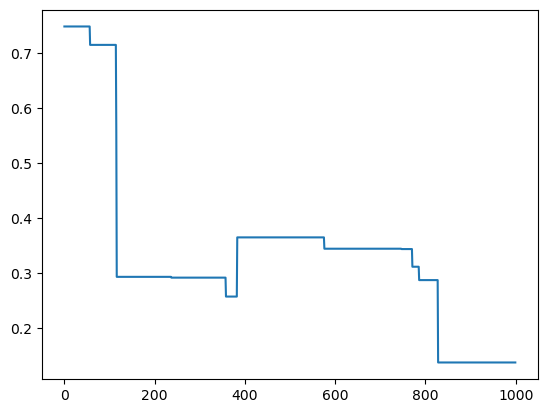

In [320]:
plt.plot(growth)

In [317]:
reframed.FBA(model, constraints=init_env)

/Users/ssulheim/anaconda3/lib/python3.11/site-packages/reframed/solvers/gurobi_solver.py:236: UserWarning: Constrained variable 'R_EX_fe2_e' not previously declared
  warn(f"Constrained variable '{r_id}' not previously declared")
/Users/ssulheim/anaconda3/lib/python3.11/site-packages/reframed/solvers/gurobi_solver.py:236: UserWarning: Constrained variable 'R_EX_h_e' not previously declared
  warn(f"Constrained variable '{r_id}' not previously declared")
/Users/ssulheim/anaconda3/lib/python3.11/site-packages/reframed/solvers/gurobi_solver.py:236: UserWarning: Constrained variable 'R_EX_mobd_e' not previously declared
  warn(f"Constrained variable '{r_id}' not previously declared")
/Users/ssulheim/anaconda3/lib/python3.11/site-packages/reframed/solvers/gurobi_solver.py:236: UserWarning: Constrained variable 'R_EX_na1_e' not previously declared
  warn(f"Constrained variable '{r_id}' not previously declared")
/Users/ssulheim/anaconda3/lib/python3.11/site-packages/reframed/solvers/gurobi_so

Objective: 0.1376519883140071
Status: Optimal

In [156]:
def add_reaction_from_universe(model, universe, r_id):
    r = universe.reactions[r_id]
    for m_id, _ in r.stoichiometry.items():
        if not m_id in model.metabolites:
            model.metabolites[m_id] = universe.metabolites[m_id]
    model.reactions[r_id] = r

In [308]:
def evolve_model(model, universe, timesteps = 100):
    init_env = Environment.from_compounds(media_db['M9'])
    # max_growth = reframed.FBA(universe, constraints=init_env).fobj
    # del init_env['R_EX_ni2_e']
    # del init_env['R_EX_na1_e']
    universe = universe.copy()
    init_env.apply(model)
    init_env.apply(universe)
    model_reactions = [r for r in model.reactions]
    can_be_removed = [r for r in model.reactions if not r in model.get_exchange_reactions()]
    universe_reactions = list(universe.reactions)
    
    potential_new_reactions = [x for x in universe_reactions if not x in model_reactions]
    growth = reframed.FBA(model, constraints=init_env)
    growth_arr = np.zeros(timesteps)
    n_reactions_arr = np.zeros(timesteps)
    for t in range(timesteps):
        growth_arr[t] = growth.fobj
        n_reactions_arr[t] = len(model.reactions)
        add = np.random.randint(0,2)
        if add:
            reaction_id = np.random.choice(potential_new_reactions, 1)[0]
            add_reaction_from_universe(model, universe, reaction_id)
            new_growth = reframed.FBA(model, constraints = init_env)
            delta_growth = new_growth.fobj - growth.fobj
            keep_reaction = keep(delta_growth)
            if keep_reaction:
                model_reactions.append(reaction_id)
                potential_new_reactions.remove(reaction_id)
                growth = new_growth
            else:
                model.remove_reaction(reaction_id)
        else:
            reaction_id = np.random.choice(model_reactions, 1)[0]
            model.remove_reaction(reaction_id)
            new_growth = reframed.FBA(model, constraints = init_env)
            try:
                delta_growth = new_growth.fobj - growth.fobj
            except TypeError:
                # Essential reaction deleted
                delta_growth = None
                keep_reaction = True
            else:
                if new_growth.fobj == 0:
                    keep_reaction = True
                else:
                    keep_reaction = keep(delta_growth)

            if keep_reaction:
                add_reaction_from_universe(model, universe, reaction_id)
            else:
                model_reactions.remove(reaction_id)
                potential_new_reactions.append(reaction_id)
                growth = new_growth
    return model, growth_arr, n_reactions_arr
            
            
        

In [263]:
def keep(delta_growth):
    
    keep_prob = keep_function(delta_growth)
    outcome = np.random.choice([True, False], p=[keep_prob, 1-keep_prob])
    return outcome

In [284]:
def keep_function(x):
    return 1/(1+np.exp(-10*x))

In [203]:
model.remove_reaction

0.01798620996209156

In [191]:
reframed.FBA(universe, constraints=init_env).fobj


/Users/ssulheim/anaconda3/lib/python3.11/site-packages/reframed/solvers/gurobi_solver.py:236: UserWarning: Constrained variable 'R_EX_na1_e' not previously declared
  warn(f"Constrained variable '{r_id}' not previously declared")
/Users/ssulheim/anaconda3/lib/python3.11/site-packages/reframed/solvers/gurobi_solver.py:236: UserWarning: Constrained variable 'R_EX_ni2_e' not previously declared
  warn(f"Constrained variable '{r_id}' not previously declared")


-0.0

In [283]:
keep_function(-0.1)

0.2689414213699951

In [237]:
def create_random_model(universe, media_db, media = 'M9', N_random = 500):
    selected_reactions = np.random.choice(list(universe.reactions), 500)
    n = len(universe.reactions)
    scores = np.zeros(n)
    for i,r in enumerate(universe.reactions):
        if r in selected_reactions:
            scores[i] = 1
    rs = pd.DataFrame()
    rs['normalized_score'] = scores
    rs['reaction'] = [x for x in universe.reactions]
    rs['GPR'] = ''
    init_env = Environment.from_compounds(media_db['M9'])
    model = carving.carve_model(universe, rs, inplace=False, init_env = init_env)
    model = multiGapFill(model, universe, ['M9'], media_db)
    return model
    
    
    
    